# Trabajo práctico 1
## Alumno: Lucas Barrera
### Contenido
####  Parte 1 (imágenes en /white_patch y /coord_cromaticas):
1. Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de contraste.
2. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.
3. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White patch.
#### Parte 2:
1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y visualizarlas.
2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si.
Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes,
considera que puede ser de utilidad tomar como ‘features’ a los histogramas?
3. Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente algunos de los
elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando mascaras, las regiones en imágenes
separadas.

## Parte 1
### Utilidades
A continuación se desarrollan utilidades que serán utilizadas durante el desarrollo del trabajo práctico

In [1]:
import numpy as np
import itertools

In [2]:
from abc import ABC, abstractmethod

# Clase base de abstracción de operadores de píxel
class PixelOperator(ABC):

    @abstractmethod
    def apply(self, pixel_data: np.array) -> np.array:
        pass

    @abstractmethod
    def get_result_data_type(self) -> type:
        pass


In [3]:
# Utilidad para aplicar operadores de píxel sobre una imagen
def apply_pixel_operator(input_image, operator: PixelOperator):
    h, w, _ = input_image.shape

    result_image = np.zeros(shape=input_image.shape, dtype=operator.get_result_data_type())

    for y, x in itertools.product(range(h), range(w)):
        result_image[y, x] = operator.apply(input_image[y, x])

    return result_image

In [4]:
import cv2
import matplotlib.pyplot as plt

def apply_operation_and_show_comparison(image, operator, title):    
    operation_result = apply_pixel_operator(image, operator)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_title('Imagen original')
    ax1.imshow(image)
    ax2.set_title('Imagen procesada')
    ax2.imshow(operation_result)
    plt.show()


In [5]:
import os


def get_images_from_folder(folder_path):
    for file_path in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file_path)):
            image = cv2.cvtColor(cv2.imread(
                folder_path + file_path), cv2.COLOR_BGR2RGB)
            yield [image, file_path]


### 1) Implementación de algoritmo para pasaje a coordenadas cromáticas

In [6]:
class ChromaticCoordsMapper(PixelOperator):
    def apply(self, pixel_data: np.array) -> np.array:
        values_sum = np.sum(pixel_data)

        if values_sum == 0:
            return np.zeros(pixel_data.shape, dtype=float)
        else:
            return pixel_data/values_sum
    
    def get_result_data_type(self) -> type:
        return float


In [7]:
def test_chromatic_coords_mapping_application():
    test_image = np.array([[[1, 2, 3], [1, 1, 1]],
                  [[3, 2, 1], [2, 2, 2]]])
    result = np.array([[[1/(1+2+3), 2/(1+2+3), 3/(1+2+3)], [1/(1+1+1), 1/(1+1+1), 1/(1+1+1)]],
                       [[3/(3+2+1), 2/(3+2+1), 1/(3+2+1)], [2/(2+2+2), 2/(2+2+2), 2/(2+2+2)]]])

    expected_result = apply_pixel_operator(test_image, ChromaticCoordsMapper())
    np.testing.assert_array_almost_equal(expected_result, result, 2)

test_chromatic_coords_mapping_application()

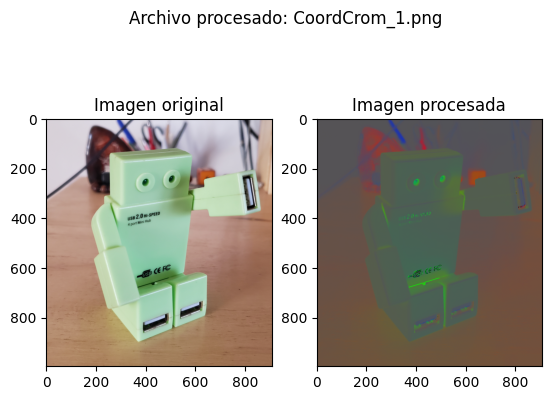

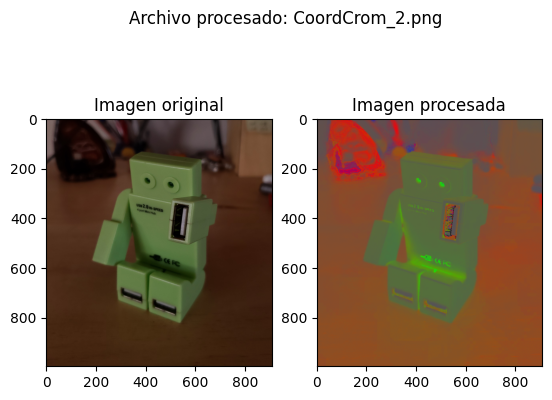

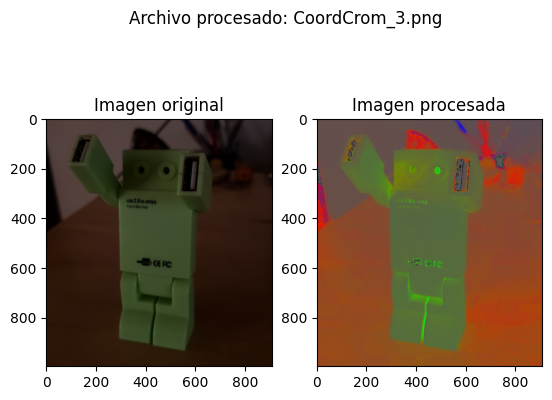

In [8]:
images = get_images_from_folder('./data/coord_cromaticas/')
for image, filename in images:
    apply_operation_and_show_comparison(image, ChromaticCoordsMapper(), 'Archivo procesado: ' + filename)

### 2) Implementación de algoritmo White Patch

In [9]:
class WhitePatchMapper(PixelOperator):
    def __init__(self, image: np.array) -> None:
        self.max_values = image.reshape(-1, image.shape[-1]).max(axis=0)

    def apply(self, pixel_data: np.array) -> np.array:
        return (255*np.multiply(pixel_data, 1/self.max_values)).astype(int)

    def get_result_data_type(self) -> type:
        return int


In [10]:
def test_white_patch_mapping_application():
    test_image = np.array([[[1, 2, 3], [1, 1, 1]],
                           [[3, 2, 1], [2, 2, 2]]])
    expected_result = (255*np.array([[[1/3, 2/2, 3/3], [1/3, 1/2, 1/3]],
                       [[3/3, 2/2, 1/3], [2/3, 2/2, 2/3]]])).astype(int)
    
    mapper = WhitePatchMapper(test_image)
    result = apply_pixel_operator(test_image, mapper)
    np.testing.assert_array_almost_equal(expected_result, result, 2)


test_white_patch_mapping_application()

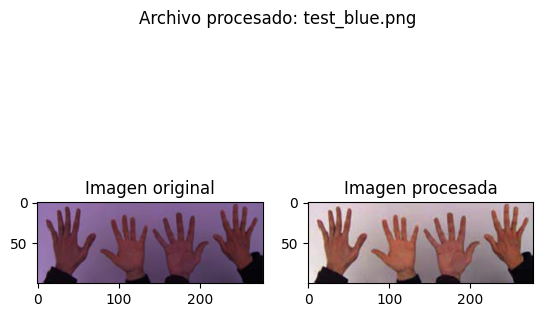

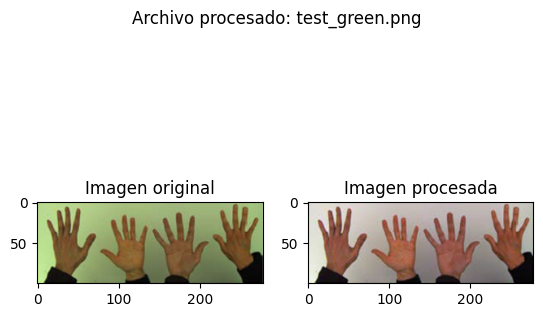

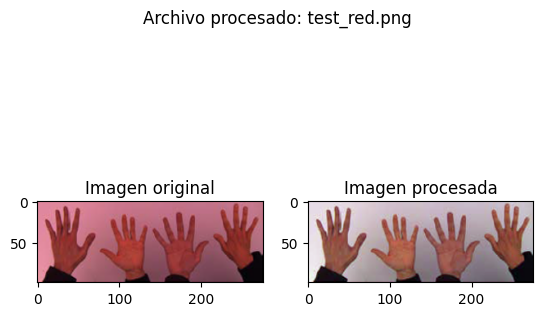

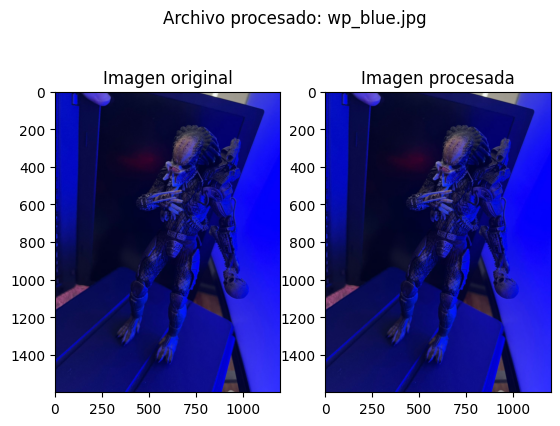

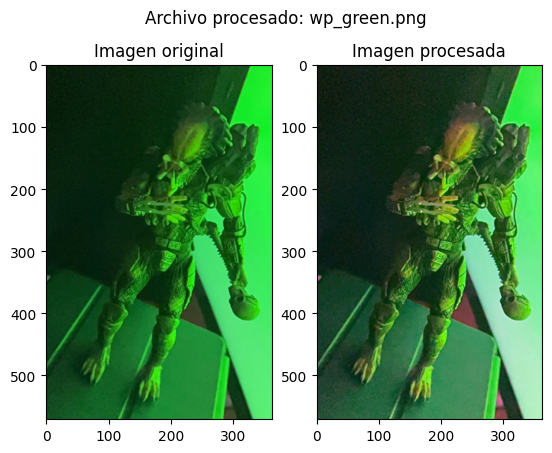

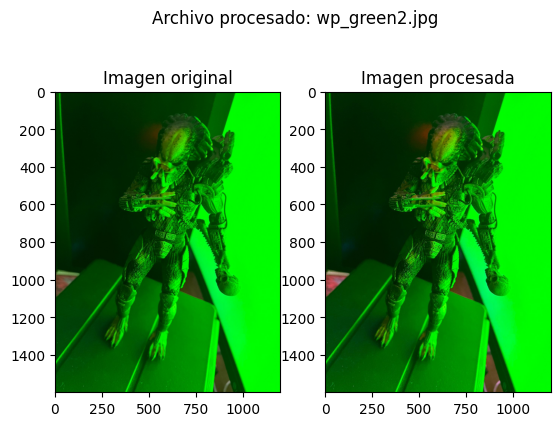

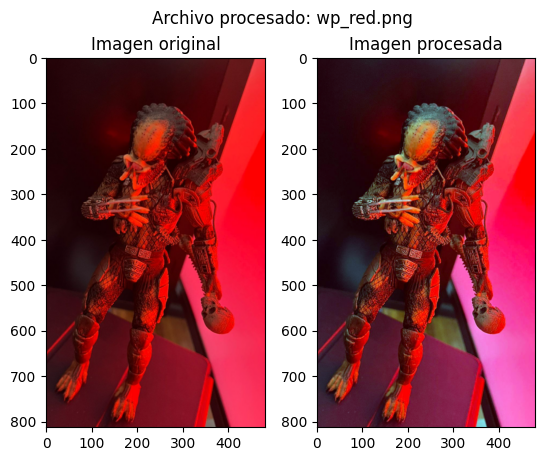

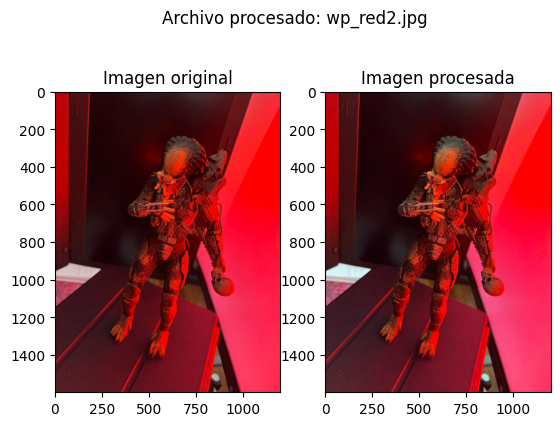

In [11]:
images = get_images_from_folder('./data/white_patch/')
for image, filename in images:
    apply_operation_and_show_comparison(image, WhitePatchMapper(image), 'Archivo procesado: ' + filename)

#### 3) Observaciones sobre algoritmo White Patch

En algunos de los ejemplos analizados anteriormente (wp_green2, wp_red2, wp_blue) vemos que el algoritmo no produce cambios significativos sobre la imagen, en cuanto a la mejora esperada por compensación de la iluminación. Esto es así, debido a que la imagen contiene al menos un píxel con un valor de canal saturado, es decir, un valor igual a 255. Analizando matemáticamente el operador vemos que, debido a la existencia de este valor, ese canal no sufrirá cambios en sus valores, para toda la imagen.

## Parte 2

### Utilidades

In [12]:
def plot_image(image, title):    
    plt.imshow(image, cmap='gray', vmin=np.iinfo(image.dtype).min, vmax=np.iinfo(image.dtype).max)
    plt.title(title)
    plt.show()

In [13]:
def plot_image_histogram(image, bins, title):
    hist, _ = np.histogram(image.ravel(), bins, [0, 256])
    plt.plot(hist)
    plt.title(title)
    plt.show()

### 1) Carga y visualización de imágenes

In [14]:
image_1 = cv2.imread('./data/img1_tp.png', cv2.IMREAD_GRAYSCALE)
image_2 = cv2.imread('./data/img2_tp.png', cv2.IMREAD_GRAYSCALE)

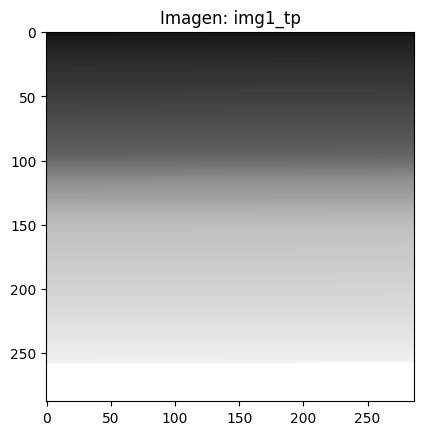

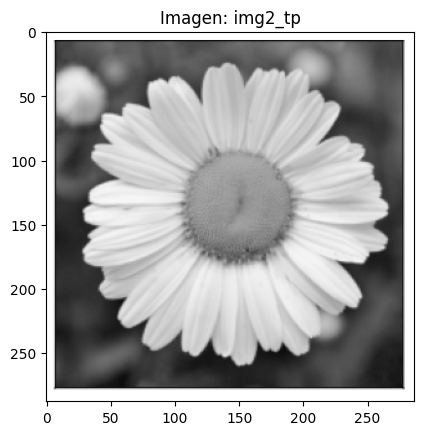

In [15]:
plot_image(image_1, 'Imagen: img1_tp')
plot_image(image_2, 'Imagen: img2_tp')

### 2) Visualización de histogramas
Luego de haber hecho distintas pruebas, se eligen 80 bins para representar el histograma. El criterio de elección está basado en inspección visual del resultado considerando el trade-off bias-varianza.

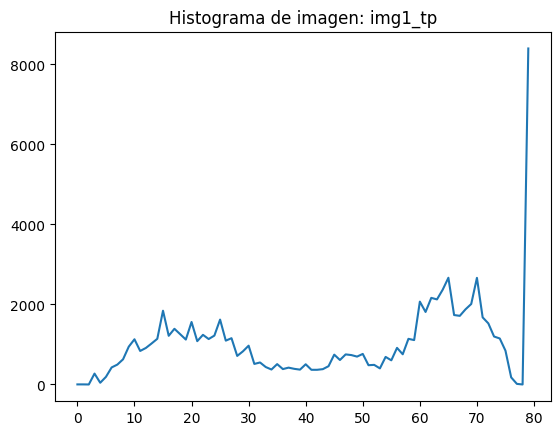

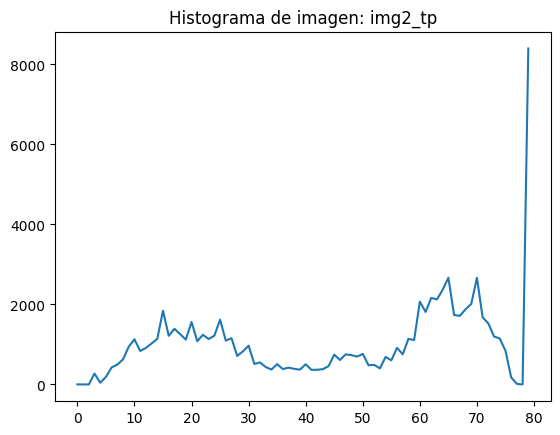

In [16]:
EJ2_BINS = 80

plot_image_histogram(image_1, EJ2_BINS, 'Histograma de imagen: img1_tp')
plot_image_histogram(image_2, EJ2_BINS, 'Histograma de imagen: img2_tp')

En los histogramas anteriores, vemos que hay una gran cantidad de píxeles blancos (de valores 255 -bin 80-). Esto se ve claramente en las imágenes: en la img2_tp se ve como borde de la imagen y en img1_tp se ve como la zona blanca inferior. Por otro lado, vemos dos zonas centradas en los bins 20  y 65 que muestran que en las imágenes existen cantidades considerables de píxeles con valores cercanos a 50 (grises oscuros) y 220 (grises claros).

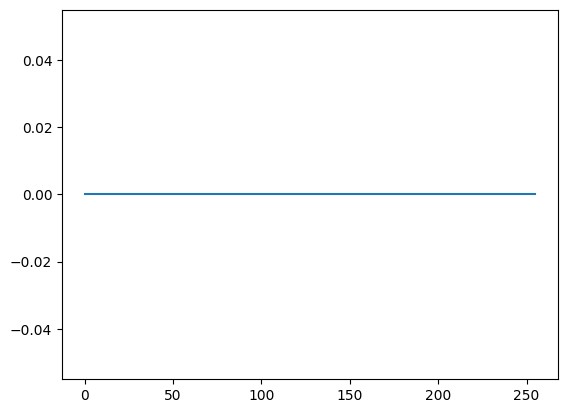

In [17]:
EJ2_BINS_comp = 256

hist_1, _ = np.histogram(image_1.ravel(), EJ2_BINS_comp, [0, 256])
hist_2, _ = np.histogram(image_2.ravel(), EJ2_BINS_comp, [0, 256])

hist_diff = hist_1-hist_2

plt.plot(hist_diff);

In [18]:
(hist_1==hist_2).all()

True

Por lo que vemos en la gráfica anterior, y lo que corroboramos mediante la comparación elemento a elemento de los bins de los histogramas, la diferencia entre los histogramas de las imágenes es nula. Por eso, podemos concluir que no es una buena opción utilizar el histograma como feature ya que, a pesar de que las imágenes son muy distintas, sus histogramas son iguales.

### 3) Segmentación

In [19]:
def show_rgb_histogram(image, bins):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figwidth(15)
    hist_r, _ = np.histogram(image[:, :, 0].ravel(), bins, [0, 256])
    ax1.plot(hist_r, color='red')
    hist_g, _ = np.histogram(image[:, :, 1].ravel(), bins, [0, 256])
    ax2.plot(hist_g, color='green')
    hist_b, _ = np.histogram(image[:, :, 2].ravel(), bins, [0, 256])
    ax3.plot(hist_b, color='blue')

    plt.show()

In [20]:
imagen_segmentacion = cv2.cvtColor(cv2.imread('./data/segmentacion.png'), cv2.COLOR_BGR2RGB)

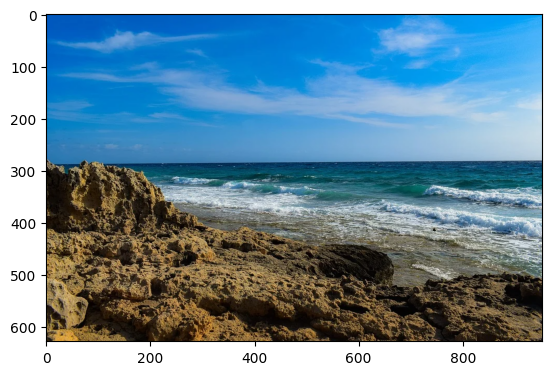

In [21]:
plt.imshow(imagen_segmentacion)
plt.show()

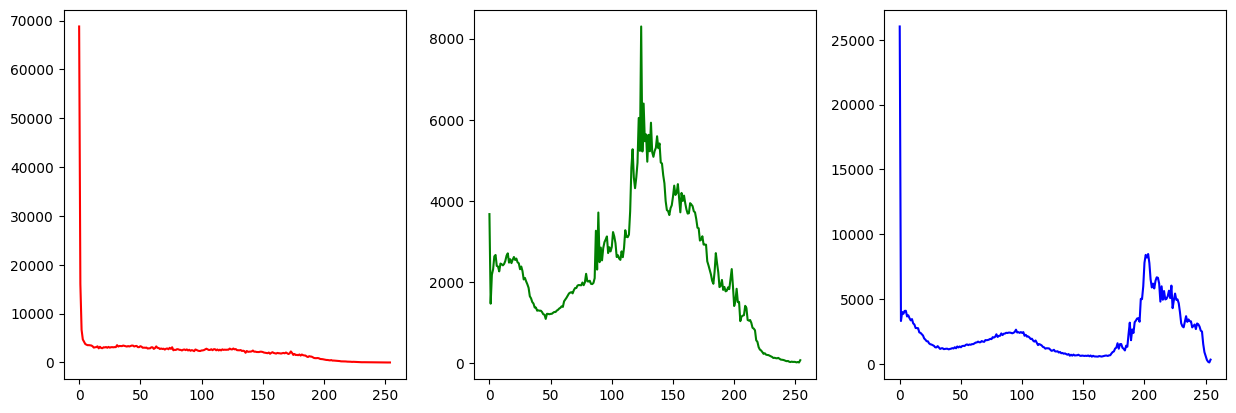

In [22]:
EJ3_BINS = 255

show_rgb_histogram(imagen_segmentacion, EJ3_BINS)

Análisis de histograma:
*  **Rojo**: Se observa que existen muchos valores "bajos" en el canal rojo. Esto es lógico ya que gran parte del cielo y el agua, contiene valores "muy  bajos" de este componente de color. También se ve una cantidad moderada de valores intermedios, que aparecen fundamentalmente en la zona de tierra/arena y partes del cielo
* **Verde**: vemos una gran cantidad de valores "medios" que aparecen fundamentalmente en el agua, que se ve turquesa, en el cielo y en parte de la tierra/arena
* **Azul**: aquí vemos que existen muchos píxeles con valores "altos" en este canal. Esto se puede explicar considerando que gran parte de la imagen, esta compuesta por cielo, que contiene una componente azul considerable. También existe una cantidad moderada de píxeles con valores "medios" y esto se puede explicar mediante las zonas de agua

### Selección de muestra para clasificación

In [23]:
def select_and_show_sample(image, sample_start, sample_end):    
    image_cpy = image.copy()
    cv2.rectangle(image_cpy, sample_start, sample_end, (255, 255, 255), 4)

    plt.imshow(image_cpy)
    plt.show()

    sample_image = image[sample_start[1]:sample_end[1], sample_start[0]:sample_end[0], :]

    plt.imshow(sample_image)
    plt.show()

    return sample_image

In [24]:
def get_hsv_limits(sample_image, sigma):
    sample_image_hsv = cv2.cvtColor(sample_image, cv2.COLOR_RGB2HSV)
    hsv_mean, hsv_std = cv2.meanStdDev(sample_image_hsv)

    mean_h, mean_s, mean_v = np.squeeze(hsv_mean)
    std_h, std_s, std_v = np.squeeze(hsv_std)

    color_l = (mean_h-sigma*std_h, mean_s-sigma*std_s, mean_v-sigma*std_v)
    color_u = (mean_h+sigma*std_h, mean_s+sigma*std_s, mean_v+sigma*std_v)

    return (color_l, color_u)


In [25]:
def segment_image_using_hsvlimits(image, lower_limit, upper_limit):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(image_hsv, lower_limit,  upper_limit)

    segmented_image = cv2.bitwise_and(image, image, mask=mask)

    plt.figure(6)
    plt.imshow(segmented_image)
    plt.show()

#### Segmentación de tierra/arena

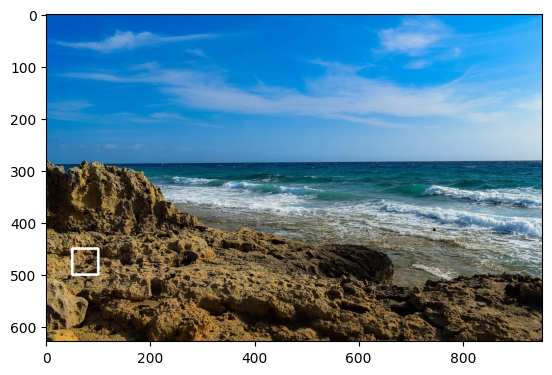

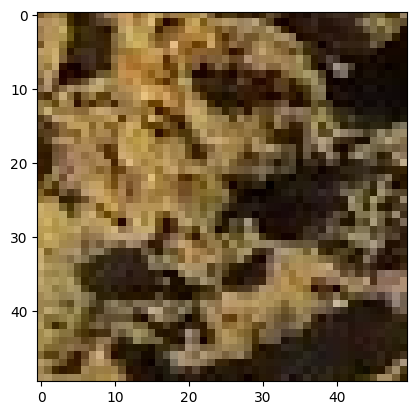

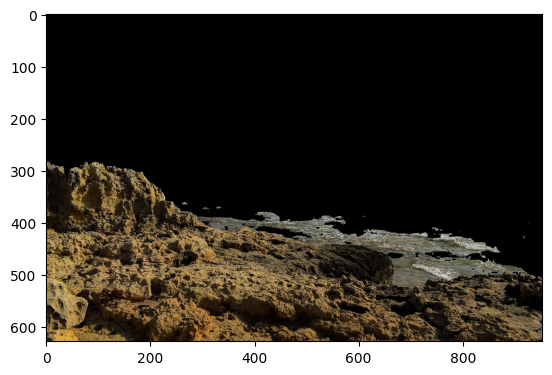

In [26]:
sample_start = (50, 450)
sample_end = (100, 500)

image_segmentacion_sample = select_and_show_sample(imagen_segmentacion, sample_start, sample_end)

SIGMA = 5

lower_limit, upper_limit = get_hsv_limits(image_segmentacion_sample, SIGMA)
segment_image_using_hsvlimits(imagen_segmentacion, lower_limit, upper_limit)

#### Segmentación de agua

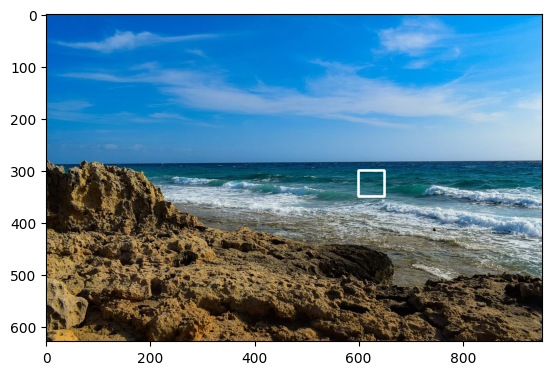

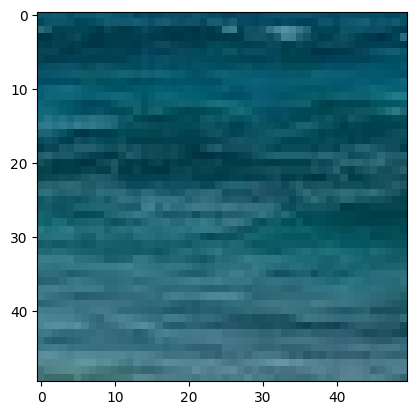

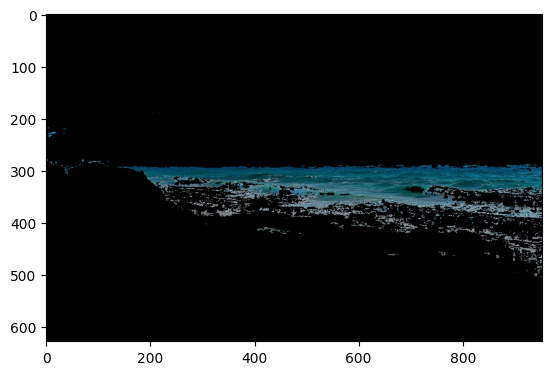

In [27]:
sample_start = (600, 300)
sample_end = (650, 350)

image_segmentacion_sample = select_and_show_sample(imagen_segmentacion, sample_start, sample_end)

SIGMA = 4

lower_limit, upper_limit = get_hsv_limits(image_segmentacion_sample, SIGMA)
segment_image_using_hsvlimits(imagen_segmentacion, lower_limit, upper_limit)

## Conclusiones
Del trabajo realizado, se puede ver que la segmentación de la tierra/arena, resulto más satisfactoria, en parte debido a la separabilidad de colores de este elemento respecto a los otros. En el caso del agua, el trabajo fue más difícil, por un lado porque se tuvo que disminuir el sigma para no detectar el cielo como agua y por otro lado, para tomar la mayor cantidad de agua posible, considerando que la espuma, es agua, pero es muy blanca, respecto al resto de agua que no se presenta en forma de espuma. Los resultados son los esperados.